In [1]:
conda install pytorch torchvision torchaudio cpuonly -c pytorch


Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\linh0\anaconda3

  added / updated specs:
    - cpuonly
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cpuonly-2.0                |                0           2 KB  pytorch
    libjpeg-turbo-2.0.0        |       h196d8e1_0         618 KB
    libuv-1.44.2               |       h2bbff1b_0         288 KB
    pytorch-2.2.1              |     py3.11_cpu_0       171.7 MB  pytorch
    pytorch-mutex-1.0          |              cpu           3 KB  pytorch
    torchaudio-2.2.1           |        py311_cpu         5.8 MB  pytorch
    torchvision-0.17.1         |        py311_cpu         6.7 MB  pytorch
    ------------------------------------------------------------
                                           Total:       185.2 MB

The following NEW packag



==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2




In [51]:
import os
import torch
import torchvision
import torchvision.transforms as t
import matplotlib.pyplot as plt
import numpy as np

In [52]:
os.listdir("C:/Users/linh0/PycharmProjects/Image-classification-project/dataset/training/training")

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [53]:
training_data_path = "C:/Users/linh0/PycharmProjects/Image-classification-project/dataset/training/training"

In [67]:
training_transform = t.Compose([t.Resize((150,150)), t.ToTensor()])

In [68]:
train_data = torchvision.datasets.ImageFolder(root = training_data_path, transform = training_transform)

In [69]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = 32, shuffle = False)

In [70]:
def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        #print(images.shape)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        #print(images.shape)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
        
    mean /= total_images_count
    std /= total_images_count
    
    return mean, std

In [71]:
get_mean_and_std(train_loader)

(tensor([0.4363, 0.4328, 0.3291]), tensor([0.2099, 0.2046, 0.2005]))

In [73]:
test_data_path = "C:/Users/linh0/PycharmProjects/Image-classification-project/dataset/validation/validation"

In [74]:
# normalize image = (image - mean)/std
mean = [0.4363, 0.4328, 0.3291]
std = [0.2135, 0.2081, 0.2044]

train_transforms = t.Compose([
    t.Resize((150,150)), 
    t.RandomHorizontalFlip(),
    t.RandomRotation(10),
    t.ToTensor(),
    t.Normalize(torch.Tensor(mean), torch.Tensor(std))
    
])
#since it is a test dataset we do not flip or rotate it
test_transforms = t.Compose([
    t.Resize((150,150)), 
    t.ToTensor(),
    t.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [75]:
train_dataset = torchvision.datasets.ImageFolder(root = training_data_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_data_path, transform = test_transforms)

In [76]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize = (11,11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([0, 8, 8, 1, 8, 6])


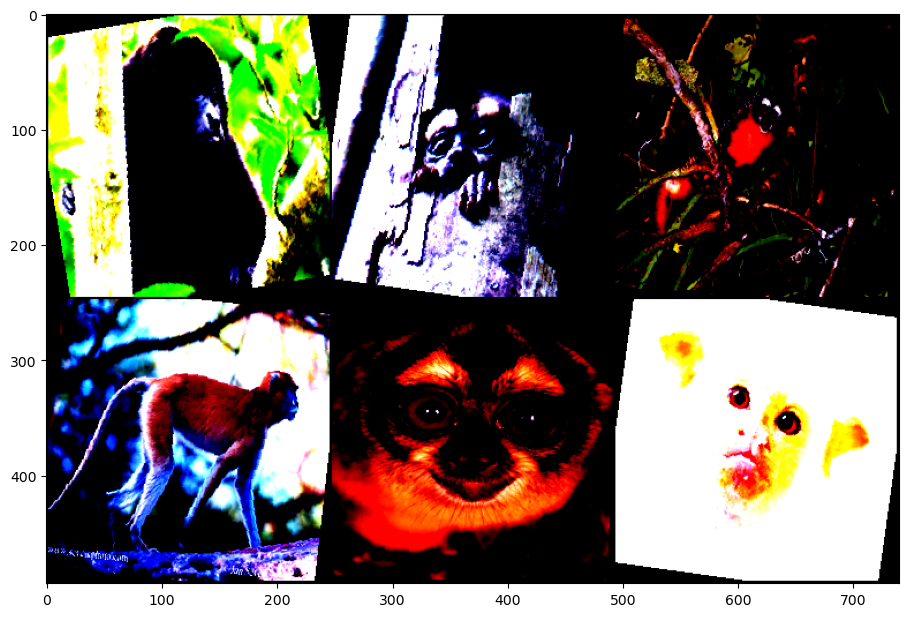

In [65]:
show_transformed_images(train_dataset)

In [77]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False)
#either try 32, 64 or 128 for batch_size

In [80]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [91]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    
    for epoch in range(n_epoch):
        print('Epoch number %d '
             % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for data in train_loader:
            images, labels = data
            image = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            
            optimizer.zero_grad()
            outputs = model(images)
            
            _, predicted = torch.max(output.data, 1)
            
            loss = criterion()

In [92]:
def eval_model_test_set(model, test_loader):


In [95]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained = False)
num_ftrs = resnet18_model.fc.in_features
num_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, num_of_classes)
device = set_device()
resnet_18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()
# SGD = Stochastic gradient descent
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)
# parameters controls how much the model change in respond to the standard error
# lr choose 0.1 to 0.001

In [96]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 100)

success
